**installing pytesseract library**

In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr

**importing necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import skimage.io as io
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True    #   To avoid errors while loading truncated images.
from PIL import Image
import re
import pytesseract
import pickle

**Mount drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Unzipping dataset**

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/images/images/image_2794.png  
  inflating: archive/images/images/image_2795.png  
  inflating: archive/images/images/image_2796.png  
  inflating: archive/images/images/image_2797.jpg  
  inflating: archive/images/images/image_2798.png  
  inflating: archive/images/images/image_2799.png  
  inflating: archive/images/images/image_28.jpg  
  inflating: archive/images/images/image_280.jpg  
  inflating: archive/images/images/image_2800.png  
  inflating: archive/images/images/image_2801.png  
  inflating: archive/images/images/image_2802.png  
  inflating: archive/images/images/image_2803.png  
  inflating: archive/images/images/image_2804.png  
  inflating: archive/images/images/image_2805.jpg  
  inflating: archive/images/images/image_2806.jpg  
  inflating: archive/images/images/image_2807.jpg  
  inflating: archive/images/images/image_2808.jpg  
  inflating: archive/images/images/image_2809.png  
  inflating: arc

**IMAGE CLASSIFICATION**

**Reading the data**

In [ ]:
import pandas as pd
dataframe=pd.read_csv("/content/archive/labelsedited.csv", encoding='latin-1')
dataframe=dataframe.drop(dataframe.columns[0], axis=1)
dataframe["overall_sentiment"]=dataframe["overall_sentiment"].map({"neutral":0, "positive":1, "very_positive":2, "negative":3, "very_negative":4})
dataframe=dataframe.sort_values(by=["overall_sentiment"], ascending=True)
dataframe=dataframe.reset_index(drop=True)
dataframe

,image_name,ocr_text,text_corrected,overall_sentiment
0,image_2803.png,WHEN I TRY TO UPLOAD MEMES TO R/MEMES AFTER NO...,WHEN I TRY TO UPLOAD MEMES TO R/MEMES AFTER NO...,0
1,image_4350.jpeg,A Drug Dealer Never Consumes !,A Drug Dealer Never Consumes !,0
2,image_5928.jpg,â...ALL OF THE OTHER REINDEER USED TO LAUGH ...,â...ALL OF THE OTHER REINDEER USED TO LAUGH ...,0
3,image_4348.jpg,Mark Zuckerberg You are forgiven ME MI TAS,Mark Zuckerberg You are forgiven ME MI TAS,0
4,image_2052.jpg,I POSTED A PICTURE OF ME AS HITLER AND BECAME ...,I POSTED A PICTURE OF ME AS HITLER AND BECAME ...,0
...,...,...,...,...
7087,image_2229.jpg,IT'S SIMPLE WE LET CONFESSION BEAR KILL THE MA...,IT'S SIMPLE WE LET CONFESSION BEAR KILL THE MA...,4
7088,image_3439.jpg,NIGGAS BE MAKIN'RACIST MEMES THIS IS ONE OF TH...,NIGGAS BE MAKIN'RACIST MEMES THIS IS ONE OF TH...,4
7089,image_1625.jpg,LEAVE THE GUN TAKE THE CHEERIOS MC memecenter....,LEAVE THE GUN TAKE THE CHEERIOS MC memecenter....,4
7090,image_3395.jpg,HOW CAN THIS RACIST WHEN YOU WHITE BASTURDS ST...,HOW CAN THIS RACIST WHEN YOU WHITE BASTURDS ST...,4


 **Determining if there's an imbalance between classes**

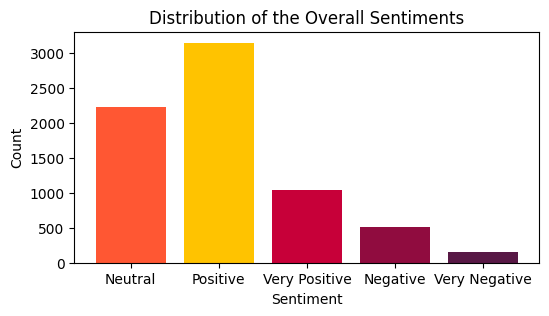

In [ ]:
import matplotlib.pyplot as plt
dataframe["overall_sentiment"].value_counts()
#   Plotting the distribution of the image sentiments.

plt.figure(figsize=(6, 3))
plt.bar(dataframe["overall_sentiment"].value_counts().index, dataframe["overall_sentiment"].value_counts().values, color=["#FFC300", "#FF5733", "#C70039", "#900C3F", "#581845"])
plt.xticks(dataframe["overall_sentiment"].value_counts().index, ["Positive", "Neutral", "Very Positive", "Negative", "Very Negative"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of the Overall Sentiments")
plt.show()

**Balancing the imbalanced classes**

In [ ]:
from sklearn.utils import resample
dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42) #   Resampling the minority class with replacement.
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])   #   Concatenating the majority and minority class pandas.DataFrames.
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)   #   Sorting the pandas.DataFrame by the overall sentiment.
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe_upsampled["overall_sentiment"].value_counts() #   Finding the frequencies of each sentiment in the pandas.DataFrame.

overall_sentiment
1    3147
0    1777
2     832
3     426
4     112
Name: count, dtype: int64

** Extracting the images from the specified directory**

In [ ]:
images=[]
for i in range(len(dataframe_upsampled)):
    image=io.imread("/content/archive/images/images/"+dataframe_upsampled["image_name"][i])
    images.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


**Pre-processing the data**

In [ ]:
#   Splitting the image data into training and testing sets.

train_images, test_images, train_labels, test_labels=train_test_split(images, dataframe_upsampled["overall_sentiment"], test_size=0.2, random_state=42)

#   Converting the training images to greyscale and resizing them to (200 x 200) pixels.

x_train=[]
for i in range(len(train_images)):
    x_train.append(np.array(Image.fromarray(train_images[i]).convert("L").resize((200, 200))))

#   Converting the testing images to greyscale and resizing them to (200 x 200) pixels.

x_test=[]
for i in range(len(test_images)):
    x_test.append(np.array(Image.fromarray(test_images[i]).convert("L").resize((200, 200))))

#   Normalising the training and testing image data.

x_train=np.array(x_train)/255.0
x_test=np.array(x_test)/255.0

#   Reshaping the training and testing image data to two-dimensional arrays.

nsamples, nx, ny=x_train.shape
x_train=x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny=x_test.shape
x_test=x_test.reshape((nsamples, nx*ny))

**Images after pre-processing**

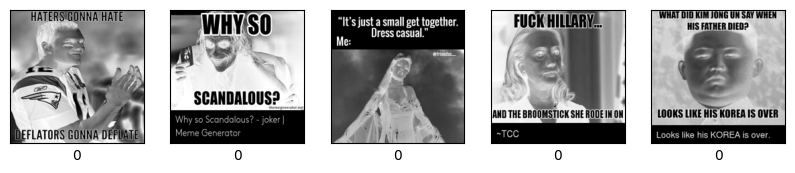

In [ ]:

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((200, 200)), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**Scaling the data**

In [ ]:


ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

**Random Forest Classifier**

In [ ]:
rf=RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42)   #   Creating an instance of the RandomForestClassifier class.
rf.fit(x_train, train_labels)   #   Training the model on the training data.

RandomForestClassifier(criterion='entropy', random_state=42)

**Predicting the labels for the classification model**

In [ ]:
rf_predictions=rf.predict(x_test)   #   Predicting the labels of the testing images.
rf_predictions

array([1, 1, 1, ..., 1, 1, 1])

**Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
rf_score=accuracy_score(test_labels, rf_predictions)    #   Calculating the accuracy of the model.
rf_f1_score=f1_score(test_labels, rf_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, rf_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", rf_score*100, "%")
print("F1-Score (Macro): ", rf_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.97      0.51      0.67       379
           1       0.67      0.99      0.80       620
           2       0.98      0.61      0.75       139
           3       1.00      0.55      0.71        97
           4       1.00      0.42      0.59        24

    accuracy                           0.76      1259
   macro avg       0.93      0.62      0.70      1259
weighted avg       0.83      0.76      0.75      1259

Accuracy:  75.85385226370136 %
F1-Score (Macro):  70.39403633047876 %


**Displaying the confusion matrix for the classification model**

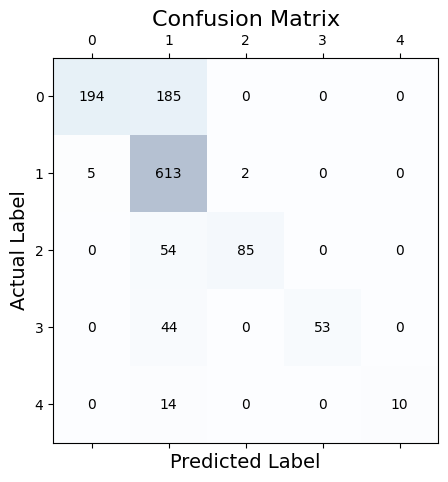

In [ ]:
confusion_matrix_rf=confusion_matrix(test_labels, rf_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_rf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_rf.shape[0]):
    for j in range(confusion_matrix_rf.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_rf[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

**K-Nearest Neighbours Classifier**

In [ ]:
knc=KNeighborsClassifier(n_neighbors=90, weights="distance", metric="minkowski", p=1)   #   Creating an instance of the KNeighborsClassifier class.
knc.fit(x_train, train_labels)  #   Training the model on the training data.

KNeighborsClassifier(n_neighbors=90, p=1, weights='distance')

**Predicting the labels for the classification model**

In [ ]:
knc_predictions=knc.predict(x_test)   #   Predicting the labels of the testing images.
knc_predictions

array([1, 1, 1, ..., 1, 1, 1])

**Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
knc_score=accuracy_score(test_labels, knc_predictions)    #   Calculating the accuracy of the model.
knc_f1_score=f1_score(test_labels, knc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, knc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", knc_score*100, "%")
print("F1-Score (Macro): ", knc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.97      0.51      0.67       379
           1       0.67      0.99      0.80       620
           2       0.99      0.61      0.76       139
           3       1.00      0.55      0.71        97
           4       1.00      0.42      0.59        24

    accuracy                           0.76      1259
   macro avg       0.93      0.61      0.70      1259
weighted avg       0.83      0.76      0.74      1259

Accuracy:  75.77442414614774 %
F1-Score (Macro):  70.3633577631966 %


**Displaying the confusion matrix for the classification model**

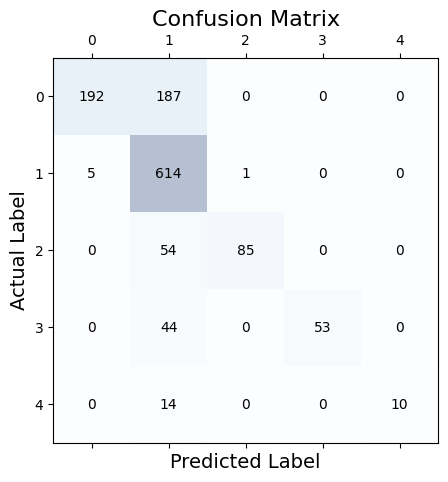

In [ ]:
confusion_matrix_knc=confusion_matrix(test_labels, knc_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_knc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_knc.shape[0]):
    for j in range(confusion_matrix_knc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_knc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

**Extra Trees Classifier**

In [ ]:
etc=ExtraTreesClassifier(n_estimators=100, random_state=42) #   Creating an instance of the ExtraTreesClassifier class.
etc.fit(x_train, train_labels)  #   Training the model on the training data.

**Predicting the labels for the classification model**

In [ ]:
etc_predictions=etc.predict(x_test) #   Predicting the labels of the testing images.
etc_predictions

array([1, 1, 1, ..., 1, 1, 1])

**Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
etc_score=accuracy_score(test_labels, etc_predictions)    #   Calculating the accuracy of the model.
etc_f1_score=f1_score(test_labels, etc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, etc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", etc_score*100, "%")
print("F1-Score (Macro): ", etc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.97      0.51      0.67       379
           1       0.67      0.99      0.80       620
           2       0.99      0.61      0.76       139
           3       1.00      0.55      0.71        97
           4       1.00      0.42      0.59        24

    accuracy                           0.76      1259
   macro avg       0.93      0.61      0.70      1259
weighted avg       0.83      0.76      0.74      1259

Accuracy:  75.85385226370136 %
F1-Score (Macro):  70.38945039202896 %


**Displaying the confusion matrix for the classification model**

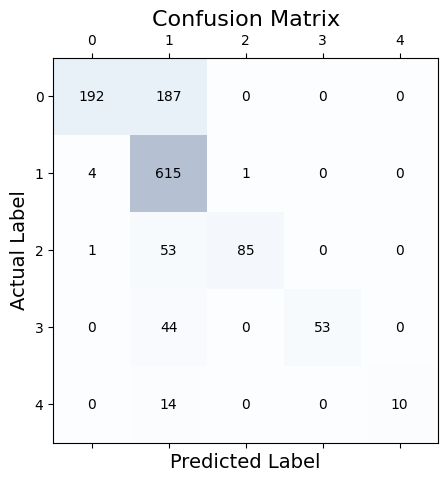

In [ ]:
confusion_matrix_etc=confusion_matrix(test_labels, etc_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_etc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_etc.shape[0]):
    for j in range(confusion_matrix_etc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_etc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

** Testing the most accurate classification model against a custom image**

Image:


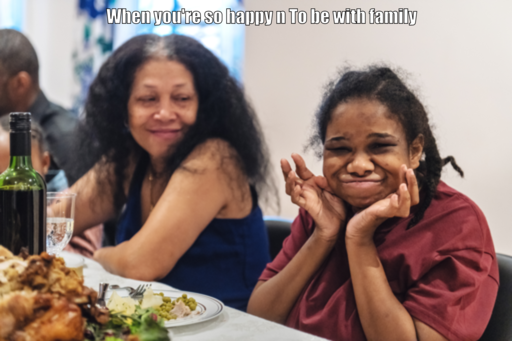

In [ ]:
image_path="/content/archive/images/images/100.png"   #   Path of the image to be tested.
image=Image.open(image_path)    #   Opening the image.
print("Image:")
image

**TEXT CLASSIFICATION**

**Reading the data (again)**

In [1]:

image=image.resize((200, 200))
image=np.array(image)
image=np.array(image)/255.0
nx, ny=image.shape
image=image.reshape((1, nx*ny))
classes=["neutral", "positive", "very_positive", "negative", "very_negative"]
answer=knc.predict(image)
print("Predicted:", classes[answer[0]])

**Balancing the imbalanced classes**

In [ ]:
#   Separating the majority and minority classes.

dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42)
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)
dataframe_upsampled["overall_sentiment"].value_counts()

overall_sentiment
1    3147
0    1777
2     832
3     426
4     112
Name: count, dtype: int64

**Applying one-hot encoding to the image sentiments**

In [ ]:
ohe_dataframe=pd.get_dummies(dataframe_upsampled, columns=["overall_sentiment"])    #   Converting all the categorical variables into numerical/dummy variables.
ohe_dataframe

,image_name,ocr_text,text_corrected,overall_sentiment_0,overall_sentiment_1,overall_sentiment_2,overall_sentiment_3,overall_sentiment_4
0,image_4339.png,X-MEN X-MEN 2 X-MEN 3 NERD.NATION._ X-MEN ORIG...,X-MEN X-MEN 2 X-MEN 3 NERD.NATION._ X-MEN ORIG...,True,False,False,False,False
1,image_3538.jpg,I CANT HELP BUT FEEL MY FATE IS SEALED quickme...,I CANT HELP BUT FEEL MY FATE IS SEALED quickme...,True,False,False,False,False
2,image_4726.jpg,I'M THE BEST COMIC VILLAIN IN FILM HISTORY. NO...,I'M THE BEST COMIC VILLAIN IN FILM HISTORY. NO...,True,False,False,False,False
3,image_662.jpg,UNHAND ME YOU PEASANT,UNHAND ME YOU PEASANT,True,False,False,False,False
4,image_5618.jpg,Country music is just farm emo,Country music is just farm emo,True,False,False,False,False
...,...,...,...,...,...,...,...,...
6289,image_3430.jpeg,WHEN IM IN SCHOOL THE TEACHER ALWAYS SAYS BLAC...,WHEN IM IN SCHOOL THE TEACHER ALWAYS SAYS BLAC...,False,False,False,False,True
6290,image_3608.jpg,VOTE FOR MY WIFE TRUMP IS SEXIST,VOTE FOR MY WIFE TRUMP IS SEXIST,False,False,False,False,True
6291,image_757.jpg,WON THE WORLD SERIES OF POKER USING POKEMON CARDS,WON THE WORLD SERIES OF POKER USING POKEMON CARDS,False,False,False,False,True
6292,image_5832.png,WE CAN NEVER FORGET THE TIME WHEN LIAM WAS ON ...,WE CAN NEVER FORGET THE TIME WHEN LIAM WAS ON ...,False,False,False,False,True


**Pre-processing the data**

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

vectorizer=TfidfVectorizer(max_features=1000, stop_words=stopwords.words("english"), ngram_range=(1, 2))    #   Creating an instance of the TfidfVectorizer class.
x=vectorizer.fit_transform(ohe_dataframe["text_corrected"].values.astype("U"))    #   Creating a bag of words model.
y=ohe_dataframe[["overall_sentiment_0", "overall_sentiment_1", "overall_sentiment_2", "overall_sentiment_3", "overall_sentiment_4"]].values
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)    #   Splitting the data into training and testing data.

#   Converting the one-hot encoded labels into a one-dimensional array.

y_train=np.argmax(y_train, axis=1)
y_test=np.argmax(y_test, axis=1)

#   Converting the sparse matrices into dense matrices.

x_train=x_train.toarray()
x_test=x_test.toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Stochastic Gradient Descent Classifier**

In [ ]:
sgd=SGDClassifier(loss="perceptron", penalty="l2", max_iter=100000, random_state=42, n_jobs=-1)    #   Creating an instance of the SGDClassifier class.
sgd.fit(x_train, y_train)   #   Training the model.

SGDClassifier(loss='perceptron', max_iter=100000, n_jobs=-1, random_state=42)

**Predicting the labels for the classification model**

In [ ]:
sgd_predictions=sgd.predict(x_test)   #   Predicting the labels of the testing data.
sgd_predictions

array([3, 1, 0, ..., 3, 1, 0])

**Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
sgd_score=accuracy_score(y_test, sgd_predictions)    #   Calculating the accuracy of the model.
sgd_f1_score=f1_score(y_test, sgd_predictions, average="weighted")    #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, sgd_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", sgd_score*100, "%")
print("F1-Score (Weighted): ", sgd_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       379
           1       0.55      0.56      0.55       620
           2       0.34      0.36      0.35       139
           3       0.37      0.23      0.28        97
           4       0.23      0.46      0.31        24

    accuracy                           0.46      1259
   macro avg       0.38      0.40      0.38      1259
weighted avg       0.46      0.46      0.46      1259

Accuracy:  46.38602065131057 %
F1-Score (Weighted):  46.18079428535787 %


**Displaying the confusion matrix for the classification model**

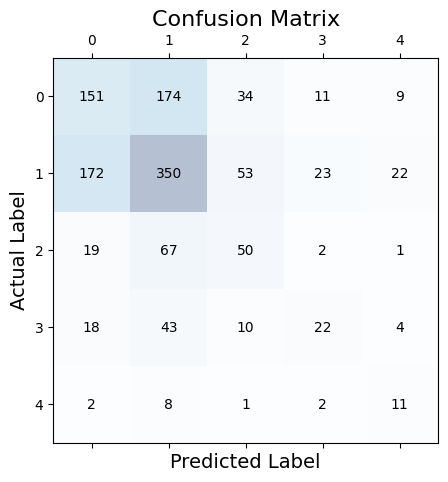

In [ ]:
confusion_matrix_sgd=confusion_matrix(y_test, sgd_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_sgd, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_sgd.shape[0]):
    for j in range(confusion_matrix_sgd.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_sgd[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

**Multinomial Naïve Bayes Classifier**

In [ ]:
mnb=MultinomialNB() #   Creating an instance of the MultinomialNB class.
mnb.fit(x_train, y_train)   #   Training the model on the training data.

MultinomialNB()

**Predicting the labels for the classification model**

In [ ]:
mnb_predictions=mnb.predict(x_test)   #   Predicting the labels of the testing data.
mnb_predictions

array([1, 1, 0, ..., 0, 1, 1])

**Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
mnb_score=accuracy_score(y_test, mnb_predictions)   #   Calculating the accuracy of the model.
mnb_f1_score=f1_score(y_test, mnb_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, mnb_predictions, zero_division=1))  #   Printing the classification report of the model.
print("Accuracy: ", mnb_score*100, "%")
print("F1-Score (Weighted): ", mnb_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.46      0.17      0.24       379
           1       0.51      0.91      0.65       620
           2       0.38      0.04      0.07       139
           3       1.00      0.00      0.00        97
           4       1.00      0.00      0.00        24

    accuracy                           0.50      1259
   macro avg       0.67      0.22      0.19      1259
weighted avg       0.53      0.50      0.40      1259

Accuracy:  50.27799841143765 %
F1-Score (Weighted):  40.25750982527675 %


**Displaying the confusion matrix for the classification model**

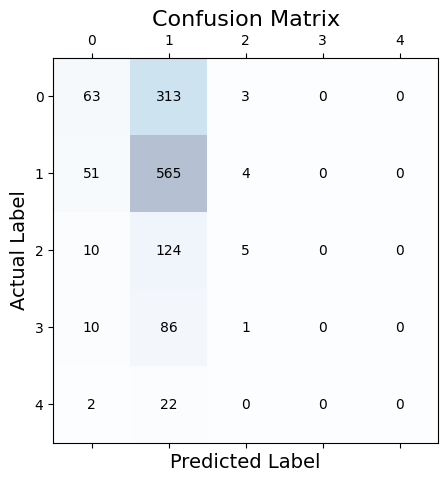

In [ ]:
confusion_matrix_mnb=confusion_matrix(y_test, mnb_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_mnb, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_mnb.shape[0]):
    for j in range(confusion_matrix_mnb.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_mnb[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

**Logistic Regression**

In [ ]:
lr=LogisticRegression(solver="liblinear", max_iter=10000, class_weight="balanced", penalty="l2", dual=True) #   Creating an instance of the LogisticRegression class.
lr.fit(x_train, y_train)    #   Training the model on the training data.

LogisticRegression(class_weight='balanced', dual=True, max_iter=10000,
                   solver='liblinear')

**Predicting the labels for the classification model**

In [ ]:
lr_predictions=lr.predict(x_test)   #   Predicting the labels of the testing data.
lr_predictions

array([3, 1, 0, ..., 3, 1, 0])

** Calculating the accuracy, and displaying the classification report for the classification model**

In [ ]:
lr_score=accuracy_score(y_test, lr_predictions)   #   Calculating the accuracy of the model.
lr_f1_score=f1_score(y_test, lr_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, lr_predictions))    #   Printing the classification report of the model.
print("Accuracy: ", lr_score*100, "%")
print("F1-Score (Weighted): ", lr_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.44      0.32      0.37       379
           1       0.55      0.60      0.57       620
           2       0.30      0.33      0.31       139
           3       0.32      0.32      0.32        97
           4       0.17      0.42      0.24        24

    accuracy                           0.46      1259
   macro avg       0.36      0.40      0.36      1259
weighted avg       0.46      0.46      0.46      1259

Accuracy:  45.909451945988884 %
F1-Score (Weighted):  45.70144238422949 %


**Displaying the confusion matrix for the classification model**

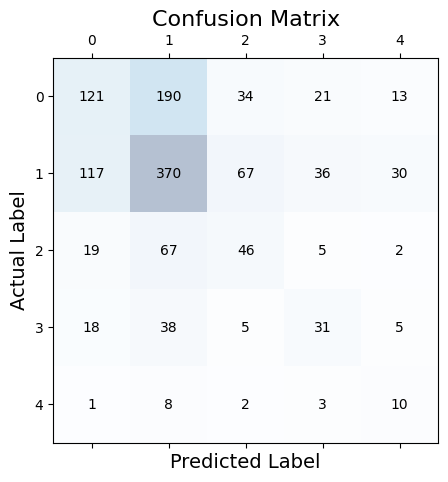

In [ ]:
confusion_matrix_lr=confusion_matrix(y_test, lr_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_lr.shape[0]):
    for j in range(confusion_matrix_lr.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_lr[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


**Calculating the average F1-score of all the analysed classification models:**

In [ ]:
#   Calculating the average F1-score of all the analyzed classification models.

f1_scores=[rf_f1_score, knc_f1_score, etc_f1_score, sgd_f1_score, mnb_f1_score, lr_f1_score]
print("Average F1-Score: ", sum(f1_scores)/len(f1_scores)*100, "%")

Average F1-Score:  57.21443183009474 %


***Testing the most accurate classification model against text extracted from a custom image ***

Image:


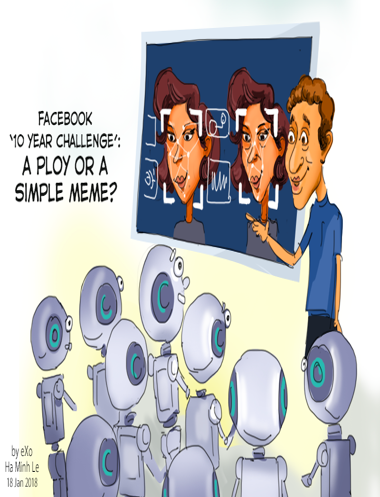

In [ ]:
image_path="/content/archive/images/images/image_10.png"   #   Path of the image
image=Image.open(image_path)
image=image.resize((380, 497))
print("Image:")
image

In [ ]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

text = pytesseract.image_to_string(image) #   Extracting the text from the image.
print("Text:")
print(text)

Text:
   

FACEBOOK
“O YEAR CHALLENGE’

APLOY OR A
SIMPLE MEME?



In [ ]:
def clean_text(text):
    text=text.lower()   #   Converting the text to lowercase.
    text=re.sub(r"[^a-z0-9]", " ", text)    #   Removing all the characters except alphabets and numbers.
    text=re.sub(r"\s+", " ", text)  #   Removing all the extra spaces.
    return text

text=clean_text(text)   #   Cleaning the text.
text=vectorizer.transform([text])    #   Transforming the text into a vector.
classes=["neutral", "positive", "very_positive", "negative", "very_negative"]   #   Defining a list of all the classes.
text=mnb.predict(text)  #   Predicting the label of the text.
print("Predicted: ", classes[text[0]])

Predicted:  positive


** Plotting the accuracies of all six analysed machine learning classification models**

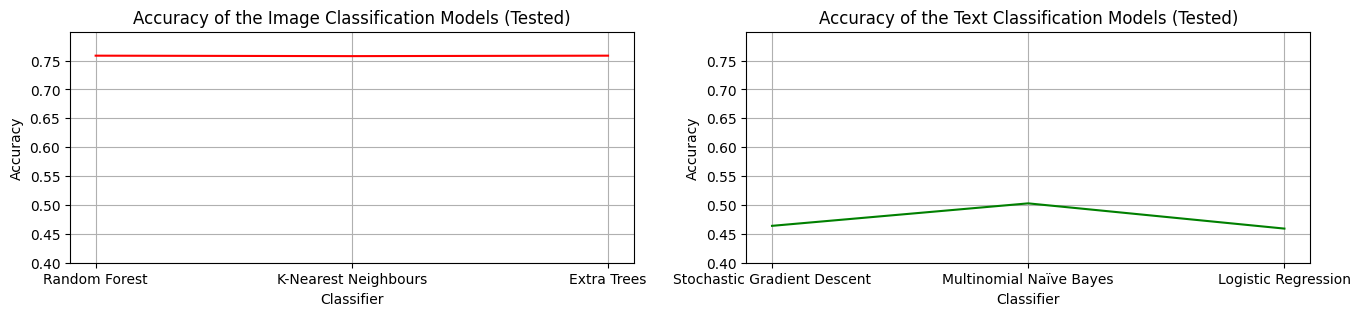

In [ ]:
#   Creating a subplot for the figures.

figure, axes=plt.subplots(1, 2, figsize=(16, 3))

#   Plotting the accuracy of the image and text classification models.

axes[0].plot(["Random Forest", "K-Nearest Neighbours", "Extra Trees"], [rf_score, knc_score, etc_score], color="red")
axes[1].plot(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"], [sgd_score, mnb_score, lr_score], color="green")

#   Setting the titles of the figures.

axes[0].set_title("Accuracy of the Image Classification Models (Tested)")
axes[1].set_title("Accuracy of the Text Classification Models (Tested)")

#   Setting the labels of the axes.

axes[0].set_xlabel("Classifier")
axes[1].set_xlabel("Classifier")
axes[0].set_ylabel("Accuracy")
axes[1].set_ylabel("Accuracy")

#   Setting the tick labels of the axes.

axes[0].set_xticks(["Random Forest", "K-Nearest Neighbours", "Extra Trees"])
axes[1].set_xticks(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"])
axes[0].set_yticks(np.arange(0.4, 0.8, 0.05))
axes[1].set_yticks(np.arange(0.4, 0.8, 0.05))

#   Adding a grid to the figures.

axes[0].set_ylim(0.4, 0.8)
axes[1].set_ylim(0.4, 0.8)

axes[0].grid()
axes[1].grid()

plt.show()